# ProbGust Vs Wind Gust Speed

Plot ProbGust Values against the Observed Wind Speed

## Import modules

In [1]:
import xarray            as xr
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import seaborn           as sns
import scipy.stats       as stats
import pint

## Set some contants

In [2]:
sns.set_theme(color_codes=True)
units = pint.UnitRegistry()
hour = pd.to_timedelta('1H')
normal_distribution = stats.norm()
start_direction = 0
end_direction = 360
city_sites = {'Harlowton':  ['UMHM', '1KM'],
              'Big Timber': ['6S0'],
              'Livingston':  ['LVM', 'MTLWM', 'MTELV']}
site_observation_options = {
    "UMHM": {'wind_speed': None, 'correction': lambda a:a + pint.Quantity(9, units('mph')).to(units('m/s')).magnitude}
}
city = 'Livingston'
city_thresholds = {
    'Livingston': [
        50.0,
        58.0,
        75.0
    ],
    'Big Timber': [
        50.0,
        58.0,
        70.0
    ],
    'Harlowton': [
        50.0,
        58.0,
        70.0
    ]
}
dot_prob_values = {
    'Livingston': {
        "Prob50": "ProbGust_50",
        "Prob60": "ProbGust_58",
        "Prob70": "ProbGust_75"
    },
    'Big Timber': {
        "Prob50": "ProbGust_50",
        "Prob60": "ProbGust_58",
        "Prob70": "ProbGust_70"
    },
    'Harlowton': {
        "Prob50": "ProbGust_50",
        "Prob60": "ProbGust_58",
        "Prob70": "ProbGust_70"
    }
}
sites = city_sites[city]
round_probs = 10

## Define utility functions

### load_forecast_grid:
Load time series from a gridded source converting units and filtering fields. Also creates the valid time field from reference time and time since reference. Can tranform column names if needed, ie for NBM 1 hour forecast.

In [3]:
def load_forecast_grid(filename, filter_fields=None, transform_columns=None):
    data = xr.open_dataset(filename).to_dataframe()
    if transform_columns is not None:
        data.columns = data.columns.to_series().apply(transform_columns)
    data['valid_time'] = data.reference_time + data.time_since_reference * hour
    data = data.set_index(['reference_time', 'valid_time']).sort_index()
    if filter_fields is None:
        filter_fields = data.columns
    return data[filter_fields]

### convert_units
Convert units of columns in a DataFrame

In [4]:
def convert_units(data, columns):
    for col in columns.keys():
        data[col] = pint.Quantity(data[col].to_numpy(), units(columns[col][0])).to(units(columns[col][1])).magnitude

### filter_missing_data
Filter rows that are filled with NaNs, ignoring time fields by default

In [5]:
def filter_missing_data(data):
    return data.dropna(how='all')

### load_observations
Load time series from observation source, converting units and filtering fields.

In [6]:
def load_observations(filename, filter_fields=None):
    data = xr.open_dataset(filename).to_dataframe().set_index('time').sort_index()
    if filter_fields is not None:
        data = data.loc[:, filter_fields]
    return data

### replace_missing_gust_with_wind
Since that gusts for AWOS/ASOS are not reported unless the gusts is sufficiently higher than sustained wind, replace missing gust values with the sustained to compare to RTMA / NBM that always has a gust value.

In [7]:
def replace_missing_gust_with_wind(data, wind_field, wind_gust_field):
    index = np.isnan(data[wind_gust_field])
    data.loc[index, wind_gust_field] = data[wind_field][index]

### get_period_maximum
Find the maximum values when rounding the time fields to nearest time period

In [8]:
def get_period_maximum(data, period='1H'):
    return data.groupby(data.index.floor(period)).max()

### convert_units
Convert units of columns in a DataFrame

In [9]:
def convert_units(data, columns):
    for col in columns.keys():
        data[col] = pint.Quantity(data[col].to_numpy(), units(columns[col][0])).to(units(columns[col][1])).magnitude

### time_match_dataset
Time-match dataset while prefixing the columns of each dataset

In [10]:
def time_match_dataset(left, right, left_prefix='obs', right_prefix='grid', left_time='time', right_time='valid_time'):
    left_data = left.copy(deep=True)
    left_data.columns = ['{0:s}_{1:s}'.format(x, left_prefix) for x in left_data.columns]
    right_data = right.copy(deep=True)
    right_data.columns = ['{0:s}_{1:s}'.format(x, right_prefix) for x in right_data.columns]
    return pd.merge(left_data, right_data, how='inner', left_on='{0:s}_{1:s}'.format(left_time, left_prefix), right_on='{0:s}_{1:s}'.format(right_time, right_prefix)).reset_index()

### filter_three_hourly
Filter NBM data to 3 hourly forecast

In [11]:
def filter_three_hourly(data, time_field='valid_time'):
    return data[data.index.get_level_values(time_field).hour % 3 == 0]

### generate_probability
Calculate the Z-Score given the bias-corrected NBM mean wind gust and standard deviation

In [12]:
def generate_prob_gust(data, threshold, unit='mph', tollerance = 0.6, mean='10_meter_wind_speed_of_gust_mean', standard_deviation='10_meter_wind_speed_of_gust_standard_deviation'):
    threshold = pint.Quantity(threshold - tollerance, units(unit)).to(units('m s**-1')).magnitude
    z_score = pd.Series((threshold - data[mean]) / data[standard_deviation], index=data.index)
    return pd.Series(np.round((100 * normal_distribution.sf(z_score))), index=data.index)


### standard_error_of_estimate
calculate the standard error from a slope and intercept

In [13]:
def standard_error_of_estimate(x, y, slope, intercept):
    x = np.array(x)
    y = np.array(y)
    error = np.inf
    if len(x) > 2:
        error = np.sqrt(np.sum(((slope * x + intercept) - y)**2) / (len(x) - 2))
    return error

### expand_timelag
Duplicate a dataframe while adjusting a datetime field by an interval to create a time-lagged dataset

In [14]:
def expand_timelag(df, interval, field='reference_time'):
    df2 = df.copy(deep=True).reset_index()
    df2[field] += pd.to_timedelta(interval)
    return df2

### reliability_correction
apply a bias-correction to the ProbGust value to improve reliability

In [15]:
def reliability_correction(location, threshold, direction, prob_gust):
    slope = 1
    intercept = 0
    r = 1
    
    if location in ['MTLWM', 'MTELV', 'LVM'] and threshold == 50 and 170 <= direction and direction <= 230:
        slope = 0.938000
        intercept = 18.523352
    elif location in ['MTLWM', 'MTELV', 'LVM'] and threshold == 58 and 170 <= direction and direction <= 230:
        slope = 0.987953
        intercept = 18.602726
    elif location in ['MTLWM', 'MTELV', 'LVM'] and threshold == 50 and 230 <= direction and direction <= 250:
        slope = 0.923174
        intercept = 5.761035
    elif location in ['MTLWM', 'MTELV', 'LVM'] and threshold == 58 and 230 <= direction and direction <= 250:
        slope = 1.019796
        intercept = 4.567449
    elif location in ['MTLWM', 'MTELV', 'LVM'] and threshold == 50 and 250 <= direction and direction <= 280:
        slope = 0.648766
        intercept = -4.546409
    elif location in ['MTLWM', 'MTELV', 'LVM'] and threshold == 58 and 250 <= direction and direction <= 280:
        slope = 0.910771
        intercept = -16.622423
    
    if intercept > 0:
        r = min(prob_gust / intercept, 1)
    
    if prob_gust > 1.01:
        prob_gust = max(min((1 - ((1 - slope) * r)) * prob_gust + (intercept * r), 100), 0)
    
    return prob_gust
        

### load_nbm_prob_gust
apply bias-correction and calculate ProbGust

In [16]:
def load_nbm_prob_gust(siteID, regression, thresholds, mean='10_meter_wind_speed_of_gust_mean', spread='10_meter_wind_speed_of_gust_standard_deviation', direction='10_meter_wind_from_direction_mean'):
    nbm_data = load_forecast_grid('../data/nbm_update/NBM_{0:s}.nc'.format(siteID), filter_fields=[mean, spread, direction])
    nbm_data = nbm_data[(nbm_data[direction] >= start_direction) & (nbm_data[direction] <= end_direction)][[mean, spread, direction]]
    nbm_data = filter_missing_data(nbm_data)
    nbm_data[mean] = regression.slope[siteID] * nbm_data[mean] + regression.intercept[siteID]
    for threshold in thresholds:
        nbm_data['ProbGust_{0:d}'.format(threshold)] = generate_prob_gust(nbm_data, threshold)
        nbm_data['ProbGust_{0:d}'.format(threshold)] = nbm_data[['ProbGust_{0:d}'.format(threshold), direction]].apply(lambda a: reliability_correction(siteID, threshold, a[direction], a['ProbGust_{0:d}'.format(threshold)]), axis=1)
    return nbm_data[[col for col in nbm_data.columns if col.find('ProbGust') > -1]]

### load_wind_gust_observation
load the wind gust, optionally filling with wind speed if gust is missing and applying a correction

In [17]:
def load_wind_gust_observation(siteID, wind_speed='10_meter_wind_speed', wind_gust='10_meter_wind_speed_of_gust', correction=None):
    obs_data = load_observations('../data/observations/{0:s}.nc'.format(siteID), 
                                 filter_fields=[x for x in [wind_speed, wind_gust] if x is not None])
    if wind_speed is not None:
        replace_missing_gust_with_wind(obs_data, wind_speed, wind_gust)
    obs_data = obs_data[[wind_gust]].reset_index().set_index('time')
    if correction is not None:
        obs_data = correction(obs_data)
    obs_data['site_id'] = siteID
    return filter_missing_data(obs_data)

## Read Bias-Correction parameters

In [18]:
regression = pd.read_json('../data/derived/regressions.json', orient='table')
regression

,slope,intercept,rvalue,pvalue,stderr
MTELV,0.893859,6.923222,0.703279,1.471382e-186,0.025618
LVM,1.022861,4.676071,0.796859,0.000000e+00,0.018798
MTLWM,0.894840,7.826072,0.683627,2.977567e-138,0.030286
6S0,0.796994,8.129035,0.685876,3.758471e-201,0.022276
1KM,0.715568,8.136230,0.735165,1.881445e-130,0.023934
UMHM,0.695138,9.328585,0.715288,1.233256e-229,0.017768


## Load Observations
take the 6 hour max value

In [19]:
obs = pd.concat([ load_wind_gust_observation(x, **site_observation_options.get(x, {})) for x in sites])
obs = obs[[x for x in obs.columns if x != 'site_id']].reset_index().set_index('time')
obs = get_period_maximum(obs, period='6H')
convert_units(obs, {'10_meter_wind_speed_of_gust': ['m s**-1', 'mph']})
obs

,10_meter_wind_speed_of_gust
time,
2014-12-31 18:00:00,29.920266
2015-01-01 00:00:00,24.166368
2015-01-01 06:00:00,24.166368
2015-01-01 12:00:00,18.412471
2015-01-01 18:00:00,18.412471
...,...
2022-01-07 06:00:00,58.384037
2022-01-07 12:00:00,62.142090
2022-01-07 18:00:00,59.840531


## Load NBM Datasets
load and filter only the first 36 hours of the forecast. Then take only the 6 hourly max value

In [20]:
nbm = pd.concat([load_nbm_prob_gust(x, regression, [int(y) for y in city_thresholds[city]]).reset_index() for x in sites]).groupby(['reference_time', 'valid_time']).max()
nbm = nbm[nbm.index.get_level_values(0) >= pd.to_datetime('2021-11-05T00:00:00')]
nbm = nbm[(nbm.index.get_level_values(1) - nbm.index.get_level_values(0)).total_seconds()/3600 <= 36].copy(deep=True)
nbm = nbm.reset_index()
nbm.valid_time = nbm.valid_time.dt.floor('6h')
nbm = nbm.groupby(['reference_time', 'valid_time']).max()

nbm = nbm.melt(value_vars=[x for x in nbm.columns if x.find('ProbGust_') > -1], var_name='Threshold', value_name='Probability', ignore_index=False).sort_index()
# nbm.Threshold = nbm.Threshold.apply(lambda a: float(a.replace('ProbGust_', '')))
nbm.Probability = np.round(nbm.Probability / round_probs, 0) * round_probs
# nbm['Dataset'] = 'NBM'
# nbm = nbm.reset_index().pivot(index=['reference_time', 'valid_time'], columns='Threshold', values="Probability")
nbm['Dataset'] = 'NBM'
nbm

Threshold  Probability Dataset
reference_time      valid_time                                           
2021-11-05 00:00:00 2021-11-05 00:00:00  ProbGust_50         30.0     NBM
                    2021-11-05 00:00:00  ProbGust_58         10.0     NBM
                    2021-11-05 00:00:00  ProbGust_75          0.0     NBM
                    2021-11-05 06:00:00  ProbGust_50         20.0     NBM
                    2021-11-05 06:00:00  ProbGust_58          0.0     NBM
...                                              ...          ...     ...
2022-01-08 12:00:00 2022-01-09 12:00:00  ProbGust_58         30.0     NBM
                    2022-01-09 12:00:00  ProbGust_75          0.0     NBM
                    2022-01-09 18:00:00  ProbGust_50         50.0     NBM
                    2022-01-09 18:00:00  ProbGust_58          0.0     NBM
                    2022-01-09 18:00:00  ProbGust_75          0.0     NBM

[2340 rows x 3 columns]

## Load WFO
load and filter the first 36 hours. Data is already a 6 hour value, no grouping

In [21]:
wfo_data = pd.read_csv('../data/byz/dot_archive.csv')
wfo_data.Issued = pd.to_datetime(wfo_data.Issued)
wfo_data.Valid = pd.to_datetime(wfo_data.Valid)
wfo_data = wfo_data[wfo_data.Issued > pd.to_datetime('2000-01-01T00:00:00')]
wfo_data = wfo_data[wfo_data.Location == city][[x for x in wfo_data.columns if x != 'Location']]
wfo_data.columns = [{"Issued": 'issued_time', "Valid": "valid_time"}.get(x,x) for x in wfo_data.columns]
wfo_data = wfo_data.set_index(['issued_time', 'valid_time', 'Filename'])
wfo_data.columns = [dot_prob_values[city].get(x) for x in wfo_data.columns]
wfo_data = wfo_data[(wfo_data.index.get_level_values(1) - wfo_data.index.get_level_values(0)).total_seconds()/3600 <= 36].copy(deep=True)
wfo_data = wfo_data.melt(value_vars=[x for x in wfo_data.columns if x.find('Prob') > -1], var_name='Threshold', value_name='Probability', ignore_index=False).sort_index()
# # wfo_data.Threshold = wfo_data.Threshold.apply(dot_prob_values[city].get)
wfo_data.Probability = np.round(wfo_data.Probability / round_probs, 0) * round_probs
# # wfo_data["Dataset"] = "Operations"

wfo_data = wfo_data.reset_index()
wfo_data['reference_time'] = wfo_data.issued_time.dt.ceil('12h') - pd.to_timedelta('12h')
# valid_verify_times = wfo_data.groupby(['reference_time']).issued_time.max().values
valid_verify_times = wfo_data.groupby(['reference_time'])[['issued_time','Filename']].max()
wfo_data = pd.merge(left=valid_verify_times, right=wfo_data, left_on=['Filename', 'reference_time', 'issued_time'], right_on=['Filename', 'reference_time', 'issued_time'], how='left')
wfo_data = wfo_data[[x for x in wfo_data.columns if x not in ['issued_time', 'Filename'] ]].set_index(['reference_time', 'valid_time'])
# wfo_data = wfo_data.reset_index().pivot(index=['reference_time', 'valid_time'], columns='Threshold', values="Probability")
# # wfo_data = wfo_data.reset_index().groupby(['reference_time']).valid_time.apply(lambda a: a.count() - a.nunique())
wfo_data["Dataset"] = "Operations"
wfo_data


Threshold  Probability     Dataset
reference_time      valid_time                                               
2021-10-13 12:00:00 2021-10-14 18:00:00  ProbGust_50          0.0  Operations
                    2021-10-14 18:00:00  ProbGust_58          0.0  Operations
                    2021-10-14 18:00:00  ProbGust_75          0.0  Operations
                    2021-10-15 00:00:00  ProbGust_50          0.0  Operations
                    2021-10-15 00:00:00  ProbGust_58          0.0  Operations
...                                              ...          ...         ...
2022-01-19 00:00:00 2022-01-20 12:00:00  ProbGust_58         10.0  Operations
                    2022-01-20 12:00:00  ProbGust_75          0.0  Operations
                    2022-01-20 18:00:00  ProbGust_50         80.0  Operations
                    2022-01-20 18:00:00  ProbGust_58         40.0  Operations
                    2022-01-20 18:00:00  ProbGust_75          0.0  Operations

[2145 rows x 3 columns]

In [22]:
# nbm.apply(lambda row: row if row.name != 'Threshold' else row.apply(lambda a:'{0}_NBM'.format(a)))

merged = pd.merge(left=pd.concat([nbm.reset_index(), wfo_data.reset_index()]),
                 right=obs.reset_index(), left_on='valid_time', right_on='time')[['reference_time', 'valid_time', 'Threshold', 'Probability', '10_meter_wind_speed_of_gust', 'Dataset']]
merged.Threshold = merged.Threshold.apply(lambda a: int(a.replace('ProbGust_', '')))
merged['Hit'] = merged.apply(lambda row: 1 if row['10_meter_wind_speed_of_gust'] >= row['Threshold'] else 0, axis=1)
merged
# print(merged.max())
reliability = merged.groupby(['Threshold', 'Probability', 'Dataset']).Hit.apply(lambda a: a.sum()/a.count() * 100).reset_index()
reliability = pd.concat([reliability, pd.DataFrame([{'Threshold': thresh, 'Probability': prob, 'Dataset': 'Perfect', 'Hit': prob} for thresh in reliability.Threshold.unique() for prob in reliability.Probability.unique()])]).sort_values(['Threshold', 'Probability', 'Dataset'])
reliability


,Threshold,Probability,Dataset,Hit
0,50,0.0,NBM,2.857143
1,50,0.0,Operations,4.958678
0,50,0.0,Perfect,0.000000
2,50,10.0,NBM,14.062500
3,50,10.0,Operations,28.571429
...,...,...,...,...
29,75,70.0,Perfect,70.000000
57,75,80.0,Operations,50.000000
30,75,80.0,Perfect,80.000000
31,75,90.0,Perfect,90.000000


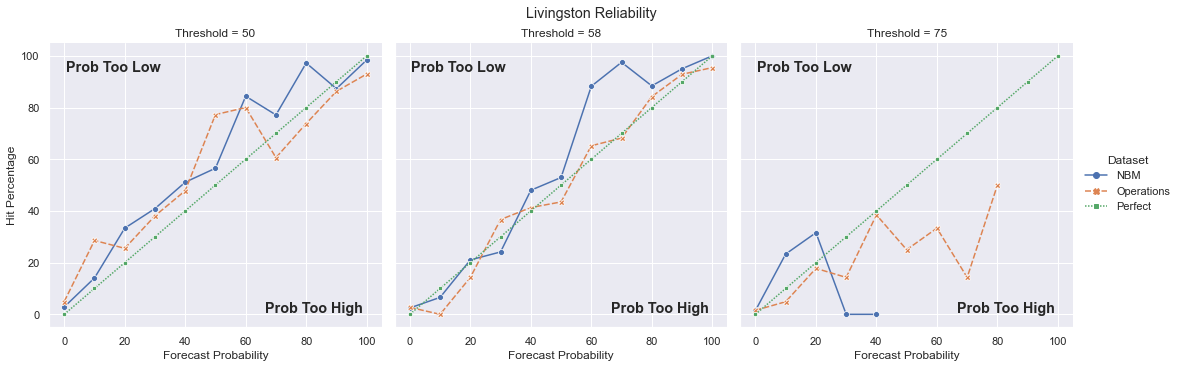

In [23]:
reliability.columns = [{'Probability': 'Forecast Probability', 'Hit': 'Hit Percentage'}.get(x, x) for x in reliability.columns]
g = sns.relplot(data=reliability, x='Forecast Probability', y='Hit Percentage', col='Threshold', hue="Dataset", kind='line', markers=True, style='Dataset')
g.fig.subplots_adjust(top=.88)
g.fig.suptitle('{0:s} Reliability'.format(city))
for _, ax in g.axes_dict.items():
    ax.text(.65, .05, "Prob Too High", transform=ax.transAxes, fontweight="bold", fontsize="large")
    ax.text(.05, .90, "Prob Too Low", transform=ax.transAxes, fontweight="bold", fontsize="large")
g.savefig('output/{0}_DOT_performance.png'.format(city.replace(' ', '')))